# UNET MODEL
> Created July. 2025 <br>
> Nikhil Bisht<br>

# Definitions

In [1]:
# standard system modules
import os, sys
import h5py 
import argparse
# standard module for tabular data
import pandas as pd
import json

# standard module for array manipulation
import numpy as np
from itertools import permutations

# standard statistical module
import scipy.stats as st
from scipy import linalg
from scipy.stats import ks_2samp
import skimage as ski
from skimage.metrics import structural_similarity as ski_ssim, normalized_mutual_information as ski_nmi

# standard module for high-quality plots
from PIL import Image
import matplotlib as mp
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
mp.rcParams.update(mp.rcParamsDefault)
%matplotlib inline

# to plot pixelized images
import imageio.v3 as im

# standard research-level machine learning toolkit from Meta (FKA: FaceBook)
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize
import tables
import torchvision
from torch.utils.data import DataLoader, TensorDataset
from torchvision.utils import save_image
from modules import *

from tqdm import tqdm

# set a seed to ensure reproducibility
seed = 128
rnd  = np.random.RandomState(seed)

DATAFILE  = '/data/cb1/nbisht/anvil_scratch/projects/128/B2/datasets/nb101_ML_dataset_AllData_AutoEnc.h5'
IMAGEINPUT = '/data/cb1/nbisht/anvil_scratch/projects/128/B2/datasets/Unet/Images_Input_3D/'
IMAGEOUTPUT = '/data/cb1/nbisht/anvil_scratch/projects/128/B2/datasets/Unet/Images_Output_3D/'
CORESET  = '/data/cb1/nbisht/anvil_scratch/projects/128/B2/datasets/nb101_all_frames.h5'
DENSITYCUBES = '/data/cb1/nbisht/anvil_scratch/projects/128/B2/datasets/nb101_TimeseriesCubes_Density.npy'
MODELFILE = 'nnmodel.dict'

IMAGESIZE = 64
FRAMES = np.arange(0,90, 1)
FRAME_DIFF = 30
TEST_PERCENTAGE = 0.01

#DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
DEVICE = torch.device('cpu')

print(f'Available device: {str(DEVICE):4s}')

Available device: cpu 


# Functions

In [45]:
def img_transform(np_arr):
    return np.log10(np_arr)

def img_inverse_transform(np_arr):
    return np.power(10,np_arr)

def delete_folder_contents(folder):
    import shutil
    for filename in os.listdir(folder):
        file_path = os.path.join(folder, filename)
        try:
            if os.path.isfile(file_path) or os.path.islink(file_path):
                os.unlink(file_path)
            elif os.path.isdir(file_path):
                shutil.rmtree(file_path)
        except Exception as e:
            print('Failed to delete %s. Reason: %s' % (file_path, e))

def get_images(input_dir):
    output_dic = {}
    for filename in os.listdir(input_dir)[0:100]:
        infile = open(os.path.join(input_dir, filename), 'r')
        i_file = json.load(infile)
        num = filename.split('_')[1]
        img_dic = i_file['img']
        label = i_file['label']
        output_dic[num] = {'img': img_dic, 'label': label}
        infile.close()
    return output_dic



# Load Images

In [46]:
input_image_dic = get_images(IMAGEINPUT)
output_image_dic = get_images(IMAGEOUTPUT)
input_image_arr = []
output_image_arr = []
label_arr = []
for key in input_image_dic.keys():
    input_image_arr.append(torch.tensor(input_image_dic[key]['img']))
    output_image_arr.append(torch.tensor(output_image_dic[key]['img']))
    label_arr.append(input_image_dic[key]['label'])


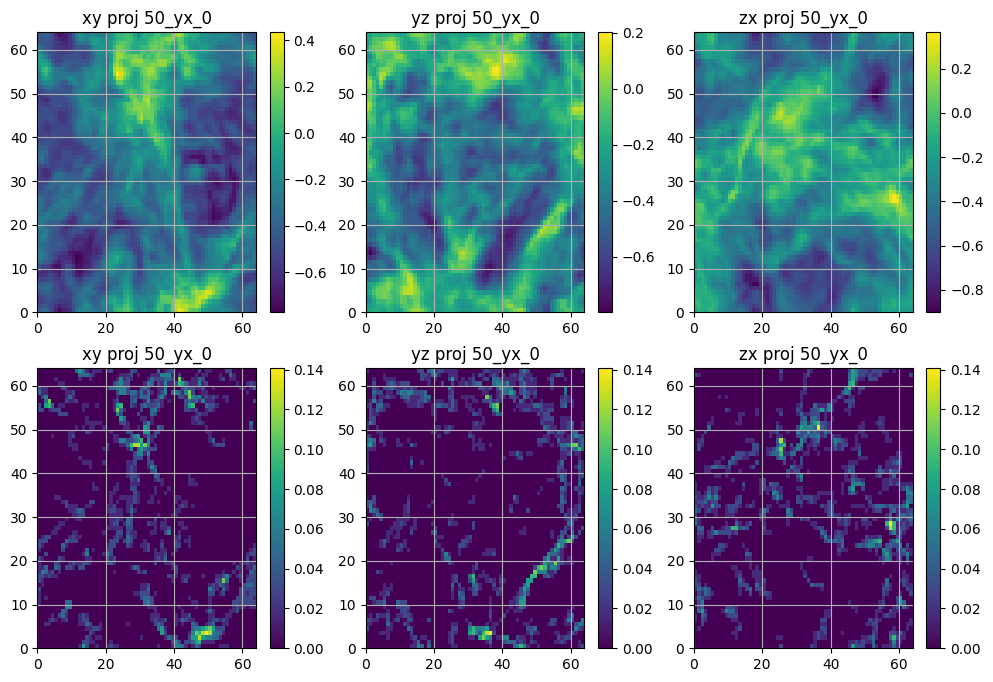

In [8]:
from scipy import ndimage
def plot_img_raw(x1, x2, x1_label, x2_label, save_filename='xy_data.png', dont_show = False):

    fig = plt.figure(figsize=(12, 8))
    fig.tight_layout()
    
    proj_arr = ['xy', 'yz', 'zx']
    for i in range(0,3):
        ax  = fig.add_subplot(2, 3, 1+i)
        c = ax.pcolormesh(np.mean(x1, axis=i).T)
        fig.colorbar(c, ax=ax)
        ax.set_title(proj_arr[i]+' proj '+str(x1_label[0])+'_'+str(x1_label[1])+'_'+str(x1_label[2]))
        ax.grid('both')

    for i in range(0,3):
        ax2  = fig.add_subplot(2, 3, 4+i)
        c = ax2.pcolormesh(np.mean(x2, axis=i).T)
        fig.colorbar(c, ax=ax2)
        ax2.set_title(proj_arr[i]+' proj '+str(x2_label[0])+'_'+str(x2_label[1])+'_'+str(x2_label[2]))
        ax2.grid('both')

    if save_filename:
        plt.savefig(save_filename)
    
    if dont_show==False:
        plt.show()
    plt.close()

#plot_img_raw(input_image_arr[0].numpy(), output_image_arr[0].numpy(), label_arr[0], label_arr[0], save_filename=False, dont_show = False)

filtered_img = torch.heaviside(input_image_arr[0]-1, torch.tensor([1.0])).numpy()
plot_img_raw(input_image_arr[0].numpy(), filtered_img, label_arr[0], label_arr[0], save_filename=False, dont_show = False)


In [ ]:
torch.heaviside(input_image_arr[0]-torch.quantile(input_image_arr[0].flatten(), 0.99), torch.tensor([1.0]))


tensor(0.9366)

In [38]:
import ipyvolume as ipv
ipv.figure()
ipv.volshow(filtered_img, level=[0.1, 0.45, 0.7], opacity=[0.02,0.02,0.2], level_width=0.1)
ipv.view(0,64)
ipv.show()

Container(children=[VBox(children=(HBox(children=(Label(value='levels:'), FloatSlider(value=0.1, max=1.0, step…

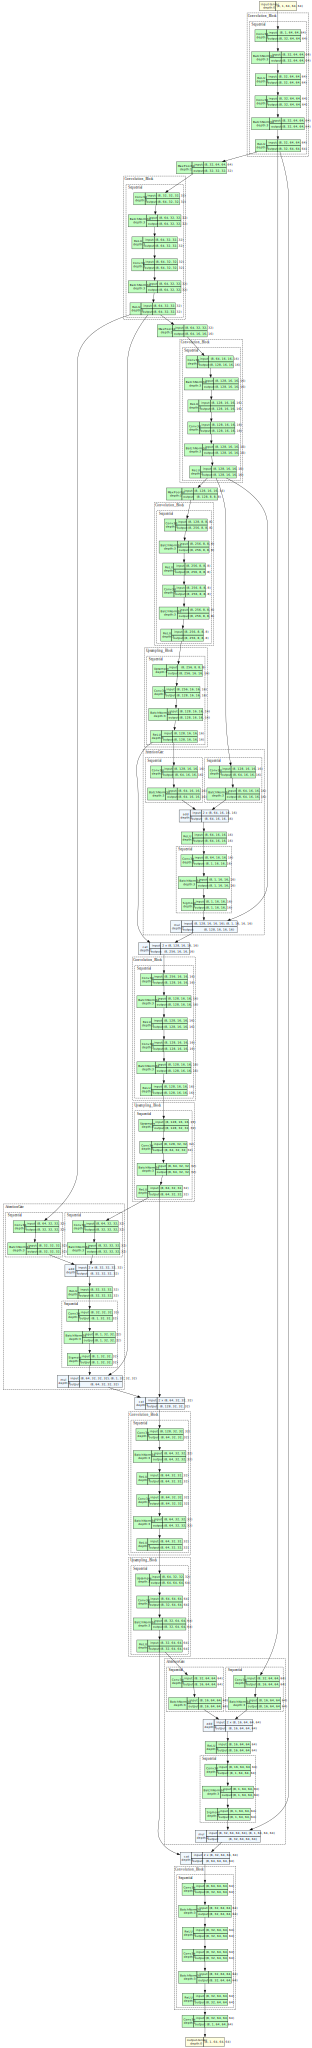

In [107]:
import torch.nn as nn
from torchmetrics.image import StructuralSimilarityIndexMeasure
from torch.utils.tensorboard import SummaryWriter

def compute_spectral_loss(pred, target):
    #pred, target are shaped [B, 1, D, H, W]
    pred_fft = torch.fft.fftn(pred.squeeze(1), dim=(1,2,3))   # [B, D, H, W], complex
    targ_fft = torch.fft.fftn(target.squeeze(1), dim=(1,2,3))
    #find the absolute magnitude, whihc gives the power spectrum
    pred_mag = torch.abs(pred_fft)
    targ_mag = torch.abs(targ_fft)
    log_pred = torch.log1p(pred_mag)
    log_true = torch.log1p(targ_mag)
    loss = F.mse_loss(log_pred, log_true)
    return loss

def hist_loss(pred, true, bins=16):
    # flatten
    p = pred.view(-1)
    t =  true.view(-1)
    # compute hist counts (differentiable via torch.histc)
    p_h = torch.histc(p, bins=bins, min=-1, max=1)
    t_h = torch.histc(t, bins=bins, min=-1, max=1)
    p_h /= p_h.sum()
    t_h /= t_h.sum()
    return F.l1_loss(p_h, t_h)

class AttentionGate(nn.Module):
    def __init__(self, F_g, F_l, F_int):
        super().__init__()
        # Reduce gating signal channels
        self.W_g = nn.Sequential(
            nn.Conv3d(F_g, F_int, kernel_size=1, bias=True, padding_mode='circular' ),
            nn.BatchNorm3d(F_int)
        )
        # Reduce encoder feature channels
        self.W_x = nn.Sequential(
            nn.Conv3d(F_l, F_int, kernel_size=1, bias=True, padding_mode='circular'),
            nn.BatchNorm3d(F_int)
        )
        # Combine & compute attention coefficients
        self.psi = nn.Sequential(
            nn.Conv3d(F_int, 1, kernel_size=1, bias=True, padding_mode='circular'),
            nn.BatchNorm3d(1),
            nn.Sigmoid()
        )
        self.relu = nn.ReLU(inplace=True)

    def forward(self, g, x):
        """
        x: encoder feature map (F_l channels)
        g: gating signal    (F_g channels) from decoder
        """
        g1 = self.W_g(g)             # [B, F_int, D, H, W]
        x1 = self.W_x(x)             # [B, F_int, D, H, W]
        psi = self.relu(g1 + x1)     # broadcast-sum
        psi = self.psi(psi)          # [B, 1, D, H, W]
        return x * psi               # gated encoder features


class Convolution_Block(nn.Module):
    def __init__(self,ch_in,ch_out):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv3d(ch_in, ch_out, kernel_size=3,stride=1,padding=1,bias=True, padding_mode='circular'),
            nn.BatchNorm3d(ch_out),
            nn.ReLU(inplace=True),
            nn.Conv3d(ch_out, ch_out, kernel_size=3,stride=1,padding=1,bias=True, padding_mode='circular'),
            nn.BatchNorm3d(ch_out),
            nn.ReLU(inplace=True)
        )

    def forward(self,x):
        x = self.conv(x)
        return x

class Upsampling_Block(nn.Module):
    def __init__(self,ch_in,ch_out):
        super().__init__()
        self.up = nn.Sequential(
            nn.Upsample(scale_factor=2),
            nn.Conv3d(ch_in,ch_out,kernel_size=3,stride=1,padding=1,bias=True, padding_mode='circular'),
		    nn.BatchNorm3d(ch_out),
			nn.ReLU(inplace=True)
        )

    def forward(self,x):
        x = self.up(x)
        return x


class UNet3D(nn.Module):
    def __init__(self, in_ch, out_ch, base_f=32):
        """
        A 3D U-Net with attention gates, 4 level deep
        Args:
            in_ch: number of input channels (e.g., 1 for grayscale)
            out_ch: number of output channels (e.g., 1 for grayscale)
            base_f: base number of filters in the first layer
        """
        super().__init__()

        self.Maxpool = nn.MaxPool3d(kernel_size=2,stride=2)

        self.Conv1 = Convolution_Block(ch_in=in_ch,ch_out=base_f)
        self.Conv2 = Convolution_Block(ch_in=base_f,ch_out=base_f*2)
        self.Conv3 = Convolution_Block(ch_in=base_f*2,ch_out=base_f*4)
        self.Conv4 = Convolution_Block(ch_in=base_f*4,ch_out=base_f*8)
        '''
        To add a deeper level with attention, add levels like this lol
        self.Conv5 = Convolution_Block(ch_in=base_f*8,ch_out=base_f*16)

        self.Up4 = Upsampling_Block(ch_in=base_f*16,ch_out=base_f*8)
        self.Att4 = AttentionGate(F_g=base_f*8,F_l=base_f*8,F_int=base_f*4)
        self.Up_conv4 = Convolution_Block(ch_in=base_f*16, ch_out=base_f*8)
        '''

        self.Up3 = Upsampling_Block(ch_in=base_f*8,ch_out=base_f*4)
        self.Att3 = AttentionGate(F_g=base_f*4,F_l=base_f*4,F_int=base_f*2)
        self.Up_conv3 = Convolution_Block(ch_in=base_f*8, ch_out=base_f*4)

        self.Up2 = Upsampling_Block(ch_in=base_f*4,ch_out=base_f*2)
        self.Att2 = AttentionGate(F_g=base_f*2,F_l=base_f*2,F_int=base_f)
        self.Up_conv2 = Convolution_Block(ch_in=base_f*4, ch_out=base_f*2)

        self.Up1 = Upsampling_Block(ch_in=base_f*2,ch_out=base_f)
        self.Att1 = AttentionGate(F_g=base_f,F_l=base_f,F_int=base_f//2)
        self.Up_conv1 = Convolution_Block(ch_in=base_f*2, ch_out=base_f)

        self.Conv_1x1 = nn.Conv3d(base_f, out_ch, kernel_size=1, stride=1, padding=0)

    def forward(self,x):
        # encoding path
        x0 = self.Conv1(x)

        #First Encoder
        x1 = self.Maxpool(x0)
        x1 = self.Conv2(x1)

        #Second Encoder
        x2 = self.Maxpool(x1)
        x2 = self.Conv3(x2)

        #Third Encoder
        x3 = self.Maxpool(x2)
        x3 = self.Conv4(x3)


        #decoding + concat path
        d2 = self.Up3(x3)
        a3 = self.Att3(g=d2,x=x2)
        d2 = torch.cat((a3,d2),dim=1)
        d2 = self.Up_conv3(d2)

        d1 = self.Up2(d2)
        a2 = self.Att2(g=d1,x=x1)
        d1 = torch.cat((a2,d1),dim=1)
        d1 = self.Up_conv2(d1)

        d0 = self.Up1(d1)
        a1 = self.Att1(g=d0,x=x0)
        d0 = torch.cat((a1,d0),dim=1)
        d0 = self.Up_conv1(d0)

        # Final 1x1 convolution to get the output channels
        return self.Conv_1x1(d0)
    
from torchview import draw_graph

model = UNet3D(in_ch=1, out_ch=1)
batch_size = 8
# device='meta' -> no memory is consumed for visualization
model_graph = draw_graph(model, input_size=(batch_size,1,64,64,64), device='meta', expand_nested=True, depth=3)
model_graph.visual_graph




In [32]:
#launch training
parser = argparse.ArgumentParser()
args = parser.parse_args(args=[])
args.batch_size = 1
args.image_size = IMAGESIZE
args.device = DEVICE
args.run_name = "Unet_3D"
args.epochs = 30
args.lr = 3e-4
args.loss_type = 'dynamic' # 'static' or 'dynamic'


train_unet(input_image_arr, output_image_arr, label_arr, args)

# Documentation for different metrics
[scikit-image documentation](https://scikit-image.org/docs/0.25.x/api/skimage.metrics.html#module-skimage.metrics)

In [23]:
def plot_comparison(input_arr, pred_output_arr, act_output_arr, label, save_filename='xy_data.png', dont_show = False):
    input_str = 'INPUT IMAGE:\n'
    pred_str = 'PREDICTED IMAGE:\n'
    act_str = 'ACTUAL IMAGE:\n'
    # Calculate metrics
    input_MSE = ski.metrics.mean_squared_error(act_output_arr, input_arr)
    input_str+= 'MSE: '+'{:0.5f}'.format(input_MSE)+'\n'
    pred_MSE = ski.metrics.mean_squared_error(act_output_arr, pred_output_arr)
    pred_str+= 'MSE: '+'{:0.5f}'.format(pred_MSE)+'\n'
    actual_MSE = ski.metrics.mean_squared_error(act_output_arr, act_output_arr)
    act_str+= 'MSE: '+'{:0.5f}'.format(actual_MSE)+'\n'

    input_NMI = ski.metrics.normalized_mutual_information(act_output_arr, input_arr, bins=100)
    input_str+= 'NMI: '+'{:0.5f}'.format(input_NMI)+'\n'
    pred_NMI = ski.metrics.normalized_mutual_information(act_output_arr, pred_output_arr, bins=100)
    pred_str+= 'NMI: '+'{:0.5f}'.format(pred_NMI)+'\n'
    actual_NMI = ski.metrics.normalized_mutual_information(act_output_arr, act_output_arr, bins=100)
    act_str+= 'NMI: '+'{:0.5f}'.format(actual_NMI)+'\n'

    inversed_input_arr = img_inverse_transform(input_arr)
    inversed_pred_output_arr = img_inverse_transform(pred_output_arr)
    inversed_act_output_arr = img_inverse_transform(act_output_arr)
    input_PSNR = ski.metrics.peak_signal_noise_ratio(inversed_act_output_arr, inversed_input_arr, data_range=np.max(inversed_input_arr) - np.min(inversed_input_arr))
    input_str+= 'PSNR: '+'{:0.5f}'.format(input_PSNR)+'\n'
    pred_PSNR = ski.metrics.peak_signal_noise_ratio(inversed_act_output_arr, inversed_pred_output_arr, data_range=np.max(inversed_pred_output_arr) - np.min(inversed_pred_output_arr))
    pred_str+= 'PSNR: '+'{:0.5f}'.format(pred_PSNR)+'\n'
    actual_PSNR = ski.metrics.peak_signal_noise_ratio(inversed_act_output_arr, inversed_act_output_arr, data_range=np.max(inversed_act_output_arr) - np.min(inversed_act_output_arr))
    act_str+= 'PSNR: '+'{:0.5f}'.format(actual_PSNR)+'\n'

    input_SSI = ski.metrics.structural_similarity(act_output_arr, input_arr, gradient=False, data_range=np.max(input_arr) - np.min(input_arr), channel_axis=None)
    input_str+= 'SSI: '+'{:0.5f}'.format(input_SSI)+'\n'
    pred_SSI = ski.metrics.structural_similarity(act_output_arr, pred_output_arr, gradient=False, data_range=np.max(pred_output_arr) - np.min(pred_output_arr), channel_axis=None)
    pred_str+= 'SSI: '+'{:0.5f}'.format(pred_SSI)+'\n'
    actual_SSI = ski.metrics.structural_similarity(act_output_arr, act_output_arr, gradient=False, data_range=np.max(act_output_arr) - np.min(act_output_arr), channel_axis=None)
    act_str+= 'SSI: '+'{:0.5f}'.format(actual_SSI)+'\n'

    input_total_density = np.sum(inversed_input_arr)
    input_str+= 'Total Density: '+'{:0.5f}'.format(input_total_density)+'\n'
    pred_total_density = np.sum(inversed_pred_output_arr)
    pred_str+= 'Total Density: '+'{:0.5f}'.format(pred_total_density)+'\n'
    act_total_density = np.sum(inversed_act_output_arr)
    act_str+= 'Total Density: '+'{:0.5f}'.format(act_total_density)+'\n'

    fig = plt.figure(figsize=(12, 12))
    
    for i in range(3):
        ax  = fig.add_subplot(3, 3, 3*i+1)
        c = ax.pcolormesh(np.mean(input_arr, axis=i).T)
        fig.colorbar(c, ax=ax)
        if i==0:
            ax.set_title('Input: '+str(label[0])+'_'+str(label[1])+'_'+str(label[2]))
        ax.grid('both')
        if i==2:
            ax.text(0.15, -0.02, input_str, fontsize=10, transform=plt.gcf().transFigure, bbox=dict(boxstyle="round", edgecolor='black', facecolor='white'))

    for i in range(3):
        ax2  = fig.add_subplot(3, 3, 3*i+2)
        c = ax2.pcolormesh(np.mean(pred_output_arr, axis=i).T)
        fig.colorbar(c, ax=ax2)
        if i==0:
            ax2.set_title('Predicted Output '+str(label[0])+'_'+str(label[1])+'_'+str(label[2]))
        ax2.grid('both')
        if i==2:
            ax2.text(0.4, -0.02, pred_str, fontsize=10, transform=plt.gcf().transFigure, bbox=dict(boxstyle="round", edgecolor='black', facecolor='white'))

    for i in range(3):
        ax3  = fig.add_subplot(3, 3, 3*i+3)
        c = ax3.pcolormesh(np.mean(act_output_arr, axis=i).T)
        fig.colorbar(c, ax=ax3)
        if i==0:
            ax3.set_title('Actual Output '+str(label[0])+'_'+str(label[1])+'_'+str(label[2]))
        ax3.grid('both')
        if i==2:
            ax3.text(0.7, -0.02, act_str, fontsize=10, transform=plt.gcf().transFigure, bbox=dict(boxstyle="round", edgecolor='black', facecolor='white'))


    if save_filename:
        plt.savefig(save_filename, bbox_inches='tight')
    
    if dont_show==False:
        plt.show()
    plt.close()

def compare_output(input_arr, output_arr, labels, args):
    # Load the trained model
    model = UNet3D(in_channels=1, out_channels=1).to(DEVICE)
    model.load_state_dict(torch.load(args.run_name+'_'+args.loss_type+'_'+MODELFILE))
    model.eval()

    with torch.no_grad():
        for i in range(len(input_arr)):
            inputs = input_arr[i].unsqueeze(0).unsqueeze(0)
            targets = output_arr[i].unsqueeze(0).unsqueeze(0)
            label = labels[i]
            inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
            outputs = model(inputs)
            # Save the output images
            output_image = outputs.cpu().numpy()
            plot_comparison(inputs[0][0].numpy(), output_image[0][0], targets[0][0].numpy(), label, save_filename='./3D_test_plots/img'+"_".join(str(x) for x in label)+'.png', dont_show = True)
    print("Testing completed and output images plotted.")

compare_output(input_image_test, output_image_test, label_test, args)

/tmp/ipykernel_1529524/1535411040.py:87: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(args.run_name+'_'+args.loss_type+'_'+MODELFILE))
/hom

Testing completed and output images plotted.


## Notes

* Add info about what frame or time is being looked at
* look at the Unet structure and draw it out
* Also, is the MSE actually good? what does it represent in terms of value? if initial is set as final, what is the MSE then? as comparison
* add NMI, PSNR, SSI and total density to loss [here's a link](https://medium.com/@baicenxiao/strategies-for-balancing-multiple-loss-functions-in-deep-learning-e1a641e0bcc0)
